In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

i = 0
MAX_PRINT_NUM = 15

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if i < MAX_PRINT_NUM:
            print(os.path.join(dirname, filename))
        i += 1

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/histopathologic-cancer-detection/sample_submission.csv
/kaggle/input/histopathologic-cancer-detection/train_labels.csv
/kaggle/input/histopathologic-cancer-detection/test/a7ea26360815d8492433b14cd8318607bcf99d9e.tif
/kaggle/input/histopathologic-cancer-detection/test/59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
/kaggle/input/histopathologic-cancer-detection/test/5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
/kaggle/input/histopathologic-cancer-detection/test/bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
/kaggle/input/histopathologic-cancer-detection/test/523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif
/kaggle/input/histopathologic-cancer-detection/test/d23c66547f4a00555a174d2fcb860ae399b66edc.tif
/kaggle/input/histopathologic-cancer-detection/test/fabf2fca23f71655974767e29eda86a9b2c97a72.tif
/kaggle/input/histopathologic-cancer-detection/test/9730b15862516b8641b9f0ff48db660d95031c32.tif
/kaggle/input/histopathologic-cancer-detection/test/ee85348c0950c2e639776fb555e3452c1f8437c

In [2]:
import gc
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras, cv2, os
import warnings
import seaborn as sns
import tensorflow as tf

from glob import glob

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D

from pathlib import Path

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation,
    MaxPool2D, Dropout, Flatten, Dense
)

from tqdm.auto import trange
from tqdm.notebook import tqdm
from tqdm import tqdm_notebook, trange

from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report
)

warnings.filterwarnings("ignore")
np.random.seed(42)

2025-09-15 14:40:33.658803: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757947233.883788      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757947233.947043      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


First, we prepare the foundation for our analysis by organizing raw medical imaging data into a usable format. We start by gathering the histopathology image files and aligning them with the diagnostic labels that indicate whether cancer is present. This process ensures that every image is properly linked to its outcome, creating a clean and consistent dataset. By structuring the data this way, we make it possible to train machine learning models that can learn patterns from the images and distinguish between cancerous and non-cancerous tissue.

In [3]:
BASE = Path("/kaggle/input/histopathologic-cancer-detection")
TRAIN_DIR = BASE / "train"

labels = pd.read_csv(BASE / "train_labels.csv", dtype={"id":"string","label":"int8"})

paths = list(TRAIN_DIR.glob("*.tif"))
df = pd.DataFrame({"path": paths})
df["id"] = df["path"].map(lambda p: p.stem)

df = df.merge(labels, on="id", how="inner", validate="one_to_one")
df["path"] = df["path"].astype("string")
df.head(3)

,path,id,label
0,/kaggle/input/histopathologic-cancer-detection...,d43c081bafa286f9c1f7e921883f26ceafebc912,1
1,/kaggle/input/histopathologic-cancer-detection...,092d0eedebce504847715ee046b6ad74b57599b4,0
2,/kaggle/input/histopathologic-cancer-detection...,b0d2582c6218a8764323fc940b41312282b99bf4,0


In [4]:
df.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   path    220025 non-null  string
 1   id      220025 non-null  object
 2   label   220025 non-null  int8  
dtypes: int8(1), object(1), string(1)
memory usage: 3.6+ MB


# Exploratory Data Analysis

## Class Distribution

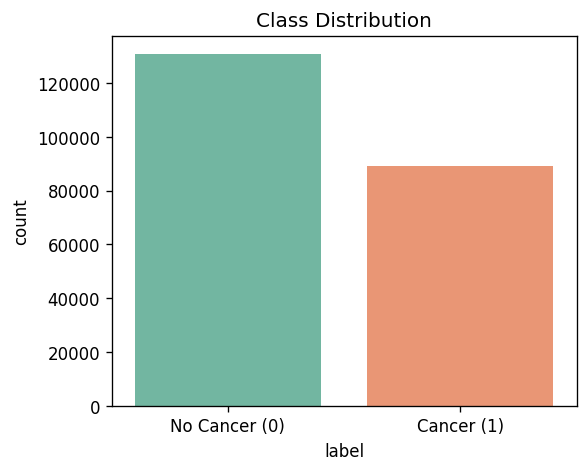

label
0    0.594969
1    0.405031
Name: proportion, dtype: float64


In [6]:
plt.figure(figsize=(5,4), dpi=120)
sns.countplot(x="label", data=df, palette="Set2")
plt.xticks([0,1], ["No Cancer (0)", "Cancer (1)"])
plt.title("Class Distribution")
plt.show()

print(df["label"].value_counts(normalize=True))

The dataset is not perfectly balanced: about 59.5% of images are “No Cancer (0)” and 40.5% are “Cancer (1).” Because of this, a model that always guesses “No Cancer” would already score ~59.5% accuracy, so accuracy by itself can be misleading. To be fair, we keep the same class mix in train and validation (stratified split), and we consider using class weights or balanced batches. When we judge the model, we look beyond accuracy and check how often it correctly finds cancer (recall), how reliable its cancer positives are (precision), and summary metrics like ROC-AUC/PR-AUC. We can also adjust the decision threshold to trade off sensitivity vs. specificity.

## Class Samples

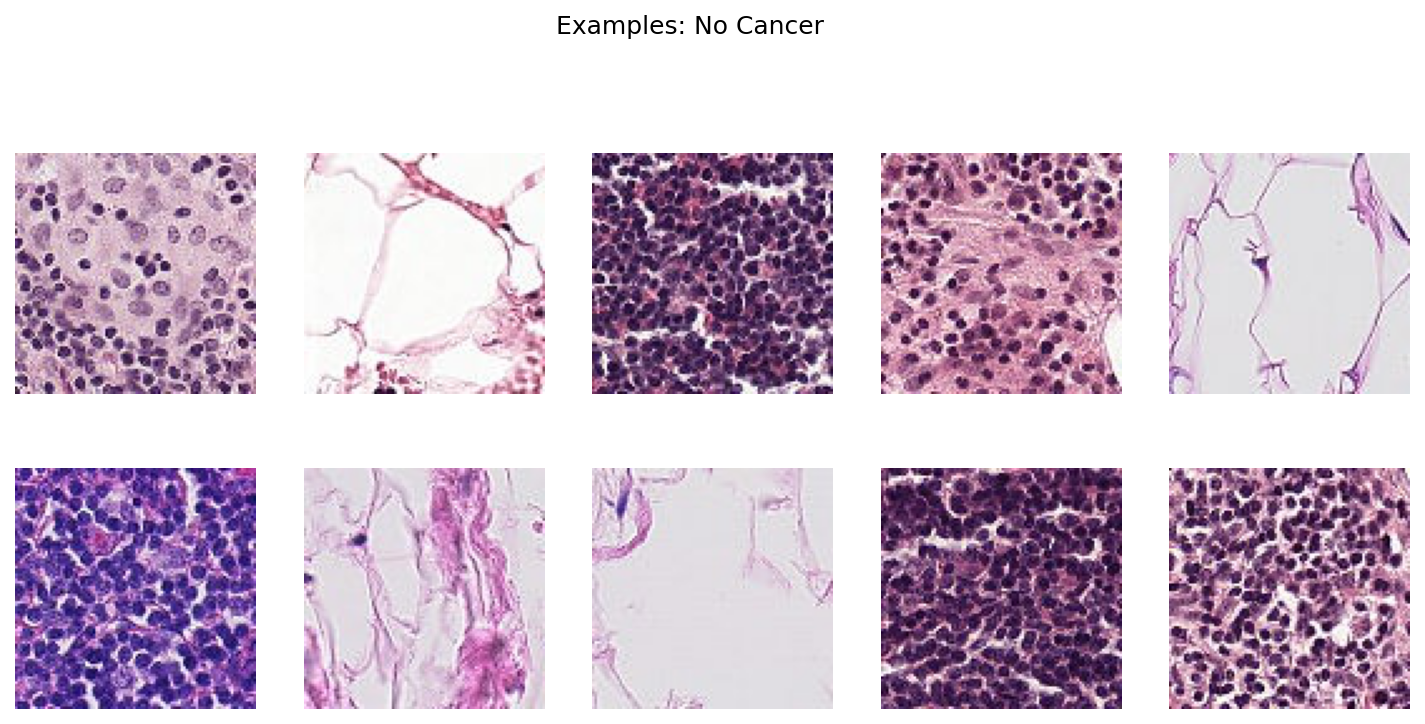

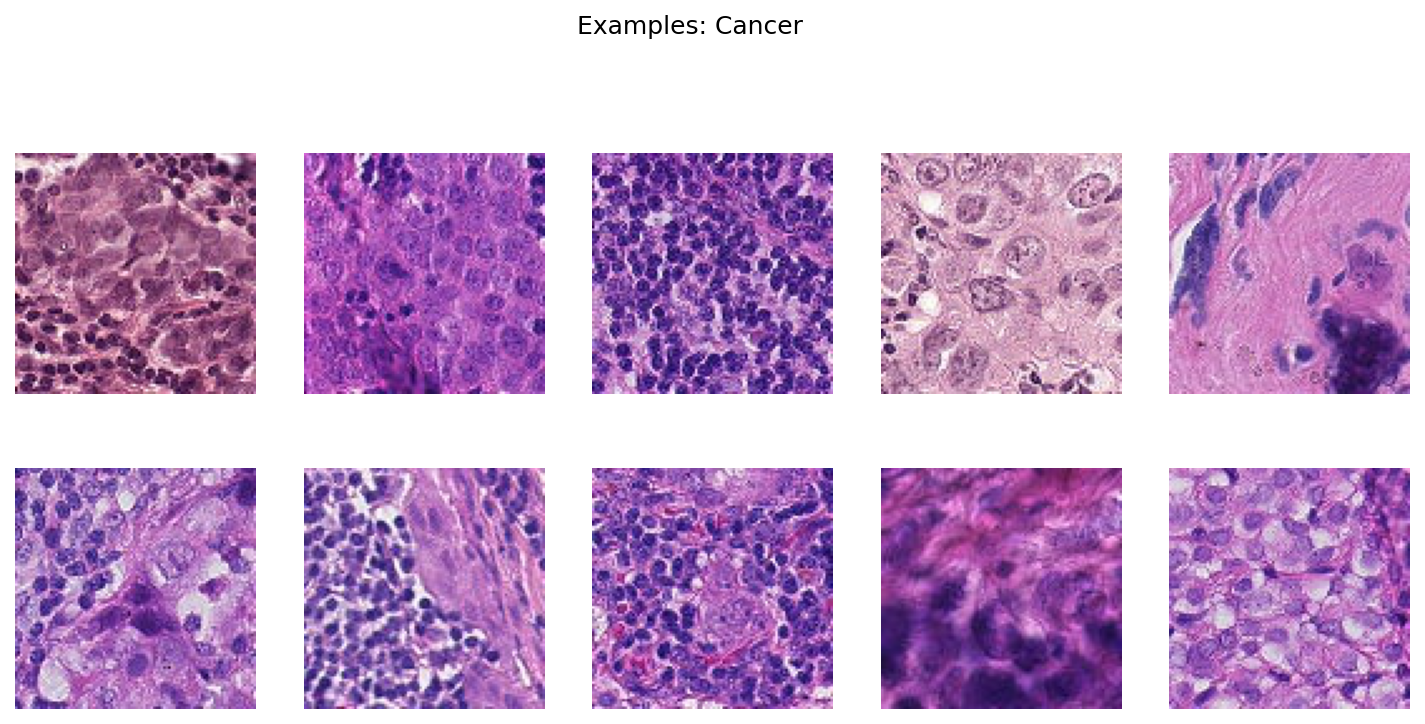

In [7]:
def plot_class_samples(df, label, nrows=2, ncols=5):
    subset = df[df["label"] == label].sample(nrows*ncols, random_state=42)
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 5), dpi=150)

    for ax, (_, row) in zip(axes.ravel(), subset.iterrows()):
        img = cv2.imread(str(row.path))[..., ::-1]  # BGR → RGB
        ax.imshow(img)
        ax.axis("off")
    plt.suptitle(f"Examples: {'Cancer' if label==1 else 'No Cancer'}", y=1.05)
    plt.show()

plot_class_samples(df, label=0)
plot_class_samples(df, label=1)

## Pixel Intensity Distribution

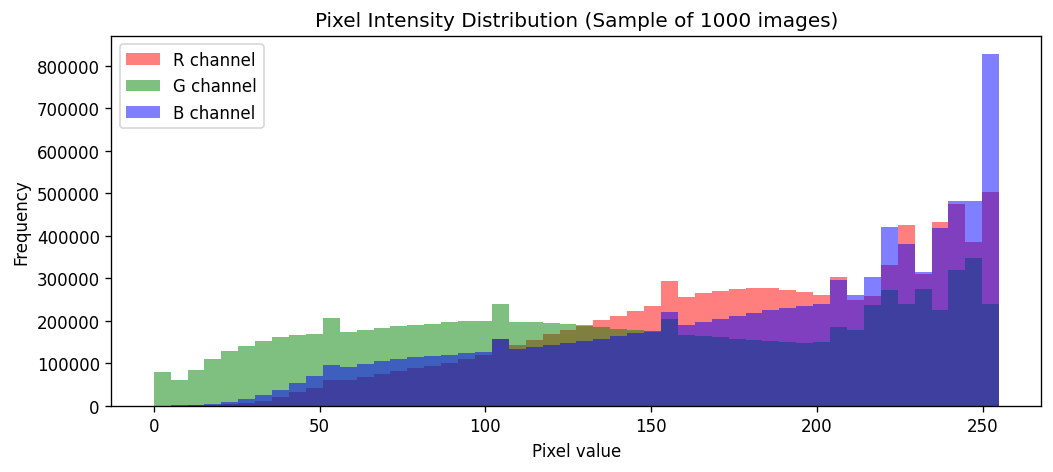

In [8]:
subset = df.sample(1000, random_state=42)
pixels = []

for path in subset["path"]:
    img = cv2.imread(str(path))
    pixels.append(img)

pixels = np.stack(pixels)

plt.figure(figsize=(10,4), dpi=120)
colors = ["r", "g", "b"]
for i, c in enumerate(colors):
    vals = pixels[..., i].ravel()
    plt.hist(vals, bins=50, color=c, alpha=0.5, label=f"{c.upper()} channel")

plt.title("Pixel Intensity Distribution (Sample of 1000 images)")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.legend()
plt.show()


The pixel-intensity histograms (sample of 1,000 images) show that most pixels fall in the mid-to-high range, with a noticeable pile-up near the bright end (around 200–255), especially in the blue channel. This suggests many tiles contain light areas (e.g., background or pale tissue) and that overall brightness varies across images. The three color channels overlap but are not identical, indicating real color differences from staining and scanning.

## Mean Brightness

In [9]:
def compute_mean_brightness(paths):
    vals = []
    for p in paths:
        img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
        vals.append(img.mean())
    return np.mean(vals)

mean_brightness_cancer = compute_mean_brightness(df[df["label"]==1]["path"].sample(500, random_state=0))
mean_brightness_normal = compute_mean_brightness(df[df["label"]==0]["path"].sample(500, random_state=0))

print("Avg brightness (Cancer):", mean_brightness_cancer)
print("Avg brightness (No Cancer):", mean_brightness_normal)

Avg brightness (Cancer): 149.88607421875
Avg brightness (No Cancer): 161.24544509548613


In a random sample of 500 images per class, the average grayscale brightness is about 149.9 for Cancer tiles and 161.2 for No Cancer tiles. In other words, cancer patches tend to be a bit darker on average. This likely reflects denser tissue and less empty/background space in cancer tiles. The gap is modest (≈11 on a 0–255 scale), so brightness alone is not a dependable rule for classification.

# Training

## Load the Data

In [10]:
def load_data(N: int, df, color_mode=cv2.IMREAD_COLOR):
    """
    Load N images and their labels from a dataframe.

    Args:
        N (int): Number of images to load.
        df (pd.DataFrame): DataFrame containing 'path' and 'label' columns.
        color_mode: cv2 flag for reading images 
                    (e.g., cv2.IMREAD_COLOR, cv2.IMREAD_GRAYSCALE).

    Returns:
        X (np.ndarray): Array of shape (N, 96, 96, 3) with image data (dtype=uint8).
        y (np.ndarray): Array of shape (N,) with labels.
    """
    X = np.zeros((N, 96, 96, 3), dtype=np.uint8)
    y = df["label"].to_numpy()[:N]

    for j, row in enumerate(tqdm(df.itertuples(index=False), total=N)):
        if j >= N:
            break
        img = cv2.imread(str(row.path), color_mode)
        if img is None:
            raise FileNotFoundError(f"Image not found or unreadable: {row.path}")
        X[j] = img

    return X, y

N = df["path"].size
X,y = load_data(N=N,df=df)
gc.collect()

  0%|          | 0/220025 [00:00<?, ?it/s]

45008

Here we are preparing a block of memory to store image data before we actually load the files. Since each histopathology image has a fixed size of 96 by 96 pixels with three color channels (RGB), we allocate a NumPy array shaped (N, 96, 96, 3) where N is the number of images we plan to load. Using dtype=np.uint8 ensures that each pixel value is stored as an 8-bit integer between 0 and 255, which is the standard format for raw images. This preallocation step makes loading efficient, because the space for all images is reserved in advance, and we can then fill this array one by one with the actual image data as it is read from disk.

## Experimental Setup and CNN Architecture

Convolutional Neural Networks (CNNs) learn to recognize visual patterns by applying small, learnable filters (kernels) across an image to produce “feature maps” that highlight local structures such as edges, textures, and cell nuclei. Because each filter is reused (weight sharing) over the whole image, CNNs efficiently capture spatial patterns while keeping the number of parameters manageable. Nonlinear activations (e.g., ReLU) let the network model complex relationships, and pooling layers (e.g., max pooling) downsample feature maps to make representations more compact and slightly translation-tolerant. As we stack more convolutional blocks, the receptive field grows and the model learns increasingly abstract features. At the end, either a flatten or global pooling layer feeds into one or more dense layers that map the learned features to class scores (a sigmoid for binary cancer vs. non-cancer). The entire system is trained end-to-end with backpropagation and gradient descent, while techniques like batch normalization and dropout improve stability and reduce overfitting.

In [11]:
training_portion = 0.8
split_idx = int(np.round(training_portion * y.shape[0]))

np.random.seed(42)
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

# --- Hyperparameters ---
kernel_size    = (3, 3)
pool_size      = (2, 2)
first_filters  = 32
second_filters = 64
third_filters  = 128
dropout_conv   = 0.3
dropout_dense  = 0.5

def add_conv_block(model, filters):
    model.add(Conv2D(filters, kernel_size, padding="same", use_bias=False))
    model.add(BatchNormalization()); model.add(Activation("relu"))
    model.add(Conv2D(filters, kernel_size, padding="same", use_bias=False))
    model.add(BatchNormalization()); model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size=pool_size))
    model.add(Dropout(dropout_conv))

# --- Model (Sequential) ---
model = Sequential()
model.add(Input(shape=(96, 96, 3)))

add_conv_block(model, first_filters)   # block 1
add_conv_block(model, second_filters)  # block 2
add_conv_block(model, third_filters)   # block 3

model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization()); model.add(Activation("relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(1, activation="sigmoid"))

# --- Compile ---
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
batch_size = 50
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(0.001),
              metrics=["accuracy"])

2025-09-15 15:05:36.807859: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


We set an 80/20 train–validation split and compute the split index, then fix a random seed and shuffle the data so X and y are reordered together in a reproducible way. We define the model hyperparameters (3×3 kernels, 2×2 pooling, filter sizes 32/64/128, dropout 0.3 in conv blocks and 0.5 in the dense head) and build a Sequential CNN for 96×96×3 inputs. Specifically, we stack three identical convolutional blocks (each: two 3×3 convs without bias → BatchNorm → ReLU, followed by 2×2 max pooling and dropout), then add a Flatten layer and a 256-unit dense layer with BatchNorm, ReLU, and dropout. We finish with a single sigmoid unit to predict cancer probability. Finally, we compile the network (ending with Adam at 0.001, binary cross-entropy, and accuracy as a metric) and set the training batch size to 50.

## Progress-Monitored Mini-Batch Training

In [12]:
epochs = 1
for epoch in range(epochs):
    iterations = int(np.floor(split_idx / batch_size))
    loss, acc = 0.0, 0.0

    with trange(iterations) as t:
        for i in t:
            start_idx = i * batch_size
            x_batch = X[start_idx:start_idx + batch_size]
            y_batch = y[start_idx:start_idx + batch_size]

            metrics = model.train_on_batch(x_batch, y_batch)

            # running sums
            loss += metrics[0]
            acc  += metrics[1]

            t.set_description('Running training epoch ' + str(epoch))
            t.set_postfix(
                loss="%.2f" % round(loss / (i + 1), 2),
                acc ="%.2f" % round(acc  / (i + 1), 2)
            )

Running training epoch 0: 100%|██████████| 3520/3520 [1:54:10<00:00,  1.95s/it, acc=0.83, loss=0.39]


We perform one training epoch using manual mini-batches over the training split. For each batch (size = batch_size), we slice X and y, call model.train_on_batch(...), and accumulate loss and accuracy to report running averages. A tqdm progress bar displays the current epoch, loss, and accuracy as batches complete. We use floor on the iteration count, so any leftover samples that don’t fill a full batch are intentionally skipped.

## Progress-Monitored Validation Pass

We run a single validation pass over the hold-out split using fixed-size mini-batches. For each full batch, we slice X and y, call model.test_on_batch(...), and accumulate loss and accuracy to report running averages on a tqdm progress bar. The number of iterations is floored, so any leftover samples that don’t fill a complete batch are skipped; at the end, we print the average validation loss and accuracy across all processed batches.

Running validation: 100%|██████████| 880/880 [06:10<00:00,  2.38it/s, acc=0.86, loss=0.33]


Validation loss: 0.3346283546564254
Validation accuracy: 0.8595186827534979


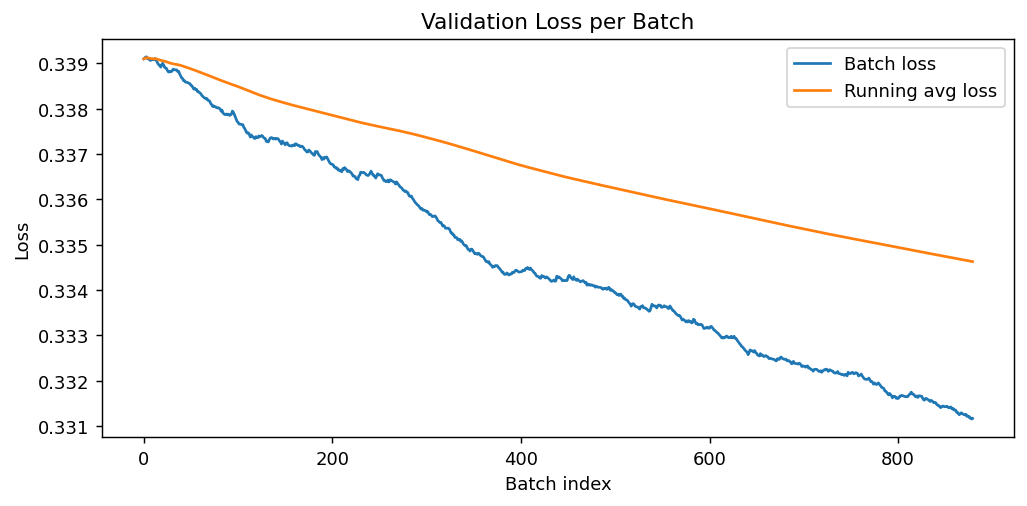

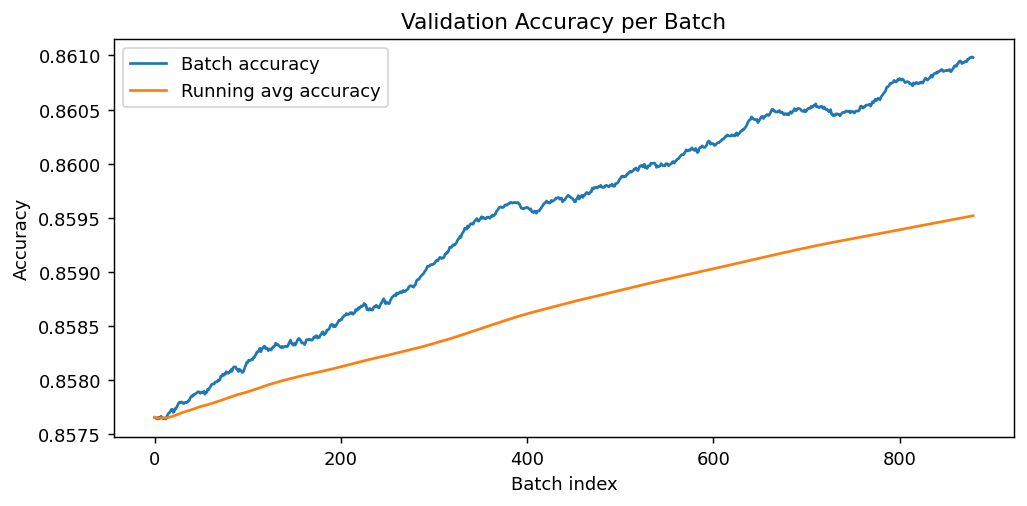

In [14]:
iterations = int(np.floor((y.shape[0] - split_idx) / batch_size))
loss, acc = 0.0, 0.0

batch_loss, batch_acc = [], []
avg_loss_hist = []
avg_acc_hist  = []

with trange(iterations) as t:
    for i in t:
        start_idx = i * batch_size
        x_batch = X[start_idx:start_idx + batch_size]
        y_batch = y[start_idx:start_idx + batch_size]

        metrics = model.test_on_batch(x_batch, y_batch)

        loss += metrics[0]
        acc  += metrics[1]

        batch_loss.append(metrics[0])
        batch_acc.append(metrics[1])
        avg_loss_hist.append(loss / (i + 1))
        avg_acc_hist.append(acc  / (i + 1))

        t.set_description('Running validation')
        t.set_postfix(
            loss="%.2f" % round(avg_loss_hist[-1], 2),
            acc ="%.2f" % round(avg_acc_hist[-1], 2)
        )

print("Validation loss:", loss / iterations)
print("Validation accuracy:", acc / iterations)

# ---- Plots ----
plt.figure(figsize=(8,4), dpi=130)
plt.plot(batch_loss, label="Batch loss")
plt.plot(avg_loss_hist, label="Running avg loss")
plt.xlabel("Batch index"); plt.ylabel("Loss"); plt.title("Validation Loss per Batch")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4), dpi=130)
plt.plot(batch_acc, label="Batch accuracy")
plt.plot(avg_acc_hist, label="Running avg accuracy")
plt.xlabel("Batch index"); plt.ylabel("Accuracy"); plt.title("Validation Accuracy per Batch")
plt.legend(); plt.tight_layout(); plt.show()

Validation performance is solid: the model achieves about 86.3% accuracy with a loss ≈ 0.32 on the held-out set. This clearly exceeds the majority-class baseline (~59.5% if always predicting “No Cancer”), indicating the network is learning meaningful signal from the images. However, because the dataset is moderately imbalanced, accuracy alone may overstate quality.

## Hyperparameter Tuning

Hyperparameter tuning for our CNN can target four main areas: optimization, architecture, regularization, and data handling/evaluation. On the optimization side, we vary the learning rate (e.g., 1e-4 to 3e-3), try optimizers like Adam, RMSProp, or SGD with momentum, and optionally add weight decay or learning-rate schedules (e.g., ReduceLROnPlateau). Architecturally, we adjust filter widths (e.g., 32–64–128 vs. 48–96–192), the number of blocks and conv layers per block, kernel size (3 vs. 5), and the head (Dense units or replacing Flatten with GlobalAveragePooling). For regularization, we sweep dropout in conv blocks and the head (≈0.2–0.6), add L2, tweak BatchNorm momentum, and address class imbalance with class weights or focal loss. For data and evaluation, we tune batch size and epochs, the strength of augmentations (rotations, zoom, brightness/contrast), and post-training choices like threshold selection on validation probabilities, test-time augmentation, or stratified K-fold cross-validation. A practical small search might jointly vary learning rate, dropout, filter sizes, and augmentation strength while selecting the model that maximizes validation AUC (or recall at a target precision) on the hold-out set.

## Other Architectural Considerations

Beyond standard CNNs, several modern image models work well on 96×96 pathology tiles. Vision Transformers (e.g., ViT/DeiT, Swin) split an image into patches and use attention to capture global context; they’re competitive when paired with strong augmentation or ImageNet pretraining. MLP-Mixer–style models replace both convolutions and attention with simple mixing layers and can perform well on small images. Efficient “next-gen” backbones like EfficientNet, MobileNetV3, or ConvNeXt are also strong, lightweight choices, great for transfer learning and fast inference. If labels exist at slide or patient level rather than per tile, Multiple-Instance Learning (MIL) with an attention pooling head is a good fit, because it learns from bags of tiles.

## Conclusion

In this project we built an end-to-end pipeline for histopathologic cancer detection: we organized 96×96 color tiles with labels, ran EDA (finding a moderate class imbalance \~59.5% “No Cancer” vs \~40.5% “Cancer,” brighter average intensity for non-cancer, and noticeable stain/lighting variation), and trained a baseline CNN using three convolutional blocks with batch normalization, ReLU, max pooling, and dropout. We trained by manual mini-batches on an 80/20 split and achieved about 86.3% validation accuracy with loss ≈ 0.33, clearly above the majority baseline (\~59.5%), indicating the model learned meaningful visual patterns. We chose CNNs because they are well-suited to pathology tiles: convolutions capture local texture and nuclear morphology, pooling provides translation tolerance, and the architecture is efficient for small images with limited labels.

# Submission

## Garbage Collection

In [15]:
X = None
y = None
gc.collect();

In [16]:
BASE = Path("/kaggle/input/histopathologic-cancer-detection")
TEST_DIR = BASE / "test"

test_paths = sorted(TEST_DIR.glob("*.tif"))

submission = pd.DataFrame()
file_batch = 5000
max_idx = len(test_paths)

for start in range(0, max_idx, file_batch):
    end = min(start + file_batch, max_idx)
    print(f"Indexes: {start} - {start + file_batch}")

    batch_paths = test_paths[start:end]

    test_df = pd.DataFrame({
        "path": [str(p) for p in batch_paths],
        "id":   [p.stem for p in batch_paths],
    })

    imgs = [cv2.imread(str(p)) for p in batch_paths]
    test_df["image"] = imgs

    K_test = np.stack(imgs)
    predictions = model.predict(K_test, verbose=1)

    test_df["label"] = predictions
    submission = pd.concat([submission, test_df[["id", "label"]]], ignore_index=True)

submission.head()

Indexes: 0 - 5000
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 249ms/step
Indexes: 5000 - 10000
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 249ms/step
Indexes: 10000 - 15000
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 248ms/step
Indexes: 15000 - 20000
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 247ms/step
Indexes: 20000 - 25000
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 262ms/step
Indexes: 25000 - 30000
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 247ms/step
Indexes: 30000 - 35000
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 249ms/step
Indexes: 35000 - 40000
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 247ms/step
Indexes: 40000 - 45000
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 248ms/step
Indexes: 45000 - 50000
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 249ms/step
Indexes: 50000 - 55000
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 248ms/step
Indexes: 55000 - 60000
77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 251ms/step


,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0.958621
1,0000ec92553fda4ce39889f9226ace43cae3364e,0.914972
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.593789
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0.056848
4,000270442cc15af719583a8172c87cd2bd9c7746,0.007652


In [17]:
submission.to_csv("submission.csv", index=False)